In [1]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")


# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)

    N_c = sum(ranked["target_class"] <= 1)
    N_t = sum(ranked["target_class"] >= 2)

    # посчитаем в отсортированном датафрейме основные показатели,
    # которые используются при расчёте Qini Score
    ranked["n_c1"] = 0
    ranked["n_t1"] = 0
    ranked.loc[ranked.target_class == 1, "n_c1"] = 1
    ranked.loc[ranked.target_class == 3, "n_t1"] = 1
    ranked["n_c1/nc"] = ranked.n_c1.cumsum() / N_c
    ranked["n_t1/nt"] = ranked.n_t1.cumsum() / N_t

    # посчитаем Qini-кривую и случайную прямую под ней
    ranked["uplift"] = round(ranked["n_t1/nt"] - ranked["n_c1/nc"], 5)
    # добавим случайную кривую
    ranked["random_uplift"] = round(
        ranked["uplift_score"].rank(pct=True, ascending=False)
        * ranked["uplift"].iloc[-1],
        5,
    )

    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked["n"], ranked["uplift"], color="r")
    plt.plot(ranked["n"], ranked["random_uplift"], color="b")
    plt.show()

    return (ranked["uplift"] - ranked["random_uplift"]).sum()


df["old_target"] = (df["target_class"] % 2).apply(int)
df

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2,0
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2,0
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12779,5,104.04,1,0,1,0,0,0,1,0,1,0,0.443421,0.063945,0.450813,0.041821,-0.082280,0,0
12780,3,558.27,1,0,1,1,0,1,0,0,0,1,0.689539,0.027868,0.224104,0.058488,0.336249,2,0
12781,11,211.30,1,0,0,0,1,0,0,0,0,1,0.421402,0.076274,0.396279,0.106045,0.115697,0,0
12782,7,335.62,1,0,1,0,0,1,0,0,0,1,0.531513,0.019835,0.381351,0.067301,0.228063,0,0


In [3]:
feature_cols = [
    "recency",
    "history",
    "used_discount",
    "used_bogo",
    "is_referral",
    "zip_code_Rural",
    "zip_code_Surburban",
    "zip_code_Urban",
    "channel_Multichannel",
    "channel_Phone",
    "channel_Web",
]
target_col = "old_target"
treatment_col = "treatment"

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25
)

from sklearn.linear_model import LogisticRegression

# s_learner = LogisticRegression(verbose=0, random_state=1)
# s_learner.fit(X=df_train[feature_cols + [treatment_col]],
#               y=df_train[target_col])

# df_test[treatment_col] = 1
# df_test['yes_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]
# df_test[treatment_col] = 0
# df_test['no_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

# uplift_vals = df_test['yes_treatment'] - df_test['no_treatment']
# df_test['uplift_score'] = uplift_vals

t_learner_1 = LogisticRegression(
    verbose=0, random_state=1
)  # создайте логистическую регрессию с random_state=1
t_learner_0 = LogisticRegression(
    verbose=0, random_state=1
)  # создайте логистическую регрессию с random_state=1

# обучите модели
df_train_1 = df_train[df_train["treatment"] == 1].reset_index(drop=True)
t_learner_1.fit(
    X=df_train_1[feature_cols + [treatment_col]], y=df_train_1[target_col]
)  # t_learner_1 — модель, обученная на выборке с воздействием

df_train_0 = df_train[df_train["treatment"] == 0].reset_index(drop=True)
t_learner_0.fit(
    X=df_train_0[feature_cols + [treatment_col]], y=df_train_0[target_col]
)  # t_learner_0 — модель, обученная на выборке без воздействия

# посчитайте и выведите intercept t_learner_1
print(t_learner_1.intercept_)

# посчитайте и выведите intercept t_learner_0
print(t_learner_0.intercept_)

[-0.66547075]
[-1.26661052]


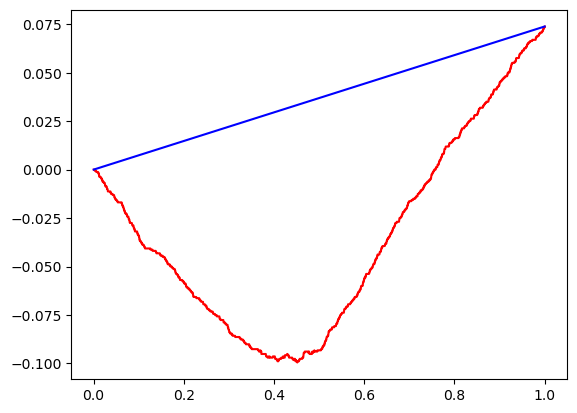

-228.00022

In [4]:
df_test["yes_treatment"] = t_learner_1.predict_proba(
    df_test[feature_cols + [treatment_col]]
)[
    :, 1
]  # ваш код применения t_learner_1
df_test["no_treatment"] = t_learner_0.predict_proba(
    df_test[feature_cols + [treatment_col]]
)[
    :, 1
]  # ваш код применения t_learner_0

uplift_vals = df_test["yes_treatment"] - df_test["no_treatment"]
df_test["uplift_score"] = uplift_vals
qini_df(df_test)